### Neighborhood-based NARVAL model on NARVAL data

In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import importlib
import for_preprocessing

import tensorflow as tf
from tensorflow.keras.models import load_model

importlib.reload(for_preprocessing)
from for_preprocessing import load_day

%config Completer.use_jedi = False  #Speeds up autocomplete

In [3]:
# Prevents crashes of the code
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[1], 'GPU')

In [4]:
root_path = '/pf/b/b309170'
data_path = os.path.join(root_path,
                         'my_work/icon-ml_data/cloud_cover_parameterization/region_based/based_on_var_interpolated_data')
model_path = os.path.join(root_path,
                          'workspace_icon-ml/cloud_cover_parameterization/region_based/saved_models')
info_file = os.path.join(root_path, 
                        'workspace_icon-ml/cloud_cover_parameterization/region_based/saved_models/model_region_based_final_1.txt')

n_layers = 27 # Is also the number of NNs

*Load data*

In [4]:
# We can work with cloud_cover_all_days_input_test_1.npy and cloud_cover_all_days_output_test_1.npy 
# (as there's a test set available)
# The corresponding model is model_clc_all_days_final_1.h5 (in model_path)
os.listdir(data_path)

['cloud_cover_output_test_1.npy',
 'cloud_cover_input_train_1.npy',
 'cloud_cover_output_train_1.npy',
 'cloud_cover_output_valid_1.npy',
 'cloud_cover_input_valid_1.npy',
 'cloud_cover_input_test_1.npy']

In [5]:
# Load all data
input_train = np.load(os.path.join(data_path, 'cloud_cover_input_train_1.npy'))
output_train = np.load(os.path.join(data_path, 'cloud_cover_output_train_1.npy'))
input_valid = np.load(os.path.join(data_path, 'cloud_cover_input_valid_1.npy')) 
output_valid = np.load(os.path.join(data_path, 'cloud_cover_output_valid_1.npy')) 
input_test = np.load(os.path.join(data_path, 'cloud_cover_input_test_1.npy')) 
output_test = np.load(os.path.join(data_path, 'cloud_cover_output_test_1.npy')) 

In [6]:
## Load data pertaining to a specific NN
n_train_samples = output_train.shape[0]
n_valid_samples = output_valid.shape[0]
n_test_samples = output_test.shape[0]
n_features = input_train.shape[1]

# Load the data into dictionaries. Can't use 3D tensors here as some features will be removed depending on the NN.
input_train_NN = {}
for i in range(n_layers):
    input_train_NN[i] = np.zeros((n_train_samples//n_layers, n_features))
    
output_train_NN = {}
for i in range(n_layers):
    input_train_NN[i] = np.zeros((n_train_samples//n_layers))
    
input_valid_NN = {}
for i in range(n_layers):
    input_valid_NN[i] = np.zeros((n_valid_samples//n_layers, n_features))
    
output_valid_NN = {}
for i in range(n_layers):
    input_valid_NN[i] = np.zeros((n_valid_samples//n_layers))
    
input_test_NN = {}
for i in range(n_layers):
    input_test_NN[i] = np.zeros((n_test_samples//n_layers, n_features))
    
output_test_NN = {}
for i in range(n_layers):
    output_test_NN[i] = np.zeros((n_test_samples//n_layers))

In [7]:
for i in range(n_layers):
    start_ind_train = (n_train_samples//27)*i
    end_ind_train = (n_train_samples//27)*(i+1)
    start_ind_valid = (n_valid_samples//27)*i
    end_ind_valid = (n_valid_samples//27)*(i+1)
    start_ind_test = (n_test_samples//27)*i
    end_ind_test = (n_test_samples//27)*(i+1) 

    input_train_NN[i] = input_train[start_ind_train:end_ind_train]
    output_train_NN[i] = output_train[start_ind_train:end_ind_train]
    input_valid_NN[i] = input_valid[start_ind_valid:end_ind_valid]
    output_valid_NN[i] = output_valid[start_ind_valid:end_ind_valid]
    input_test_NN[i] = input_test[start_ind_test:end_ind_test]  
    output_test_NN[i] = output_test[start_ind_test:end_ind_test]

In [8]:
# We remove the input variables with zero variance. We compute the resulting input dimension for the NN.
input_dim = n_features
for i in range(n_layers):
    vars_to_remove = []
    for j in range(n_features):
        if np.var(input_train_NN[i][:, j]) == 0 or np.isnan(np.var(input_train_NN[i][:, j])):
            input_dim -= 1
            vars_to_remove.append(j)
    input_test_NN[i] = np.delete(input_test_NN[i], vars_to_remove, axis=1)
    input_valid_NN[i] = np.delete(input_valid_NN[i], vars_to_remove, axis=1)
    input_train_NN[i] = np.delete(input_train_NN[i], vars_to_remove, axis=1)

In [9]:
# Checking standardization:
thresh = 1e-5
[np.abs(np.mean(input_train_NN[5][:, j]))<thresh and np.abs(np.var(input_train_NN[5][:, j])-1)<thresh for i in range(n_features)]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

*Load model*

In [9]:
models = [load_model(os.path.join(model_path, 'model_clc_all_days_final_1_%d.h5'%i)) for i in range(27)]

**First visualization method** <br>
Samples on x-axis and cloud cover on y-axis

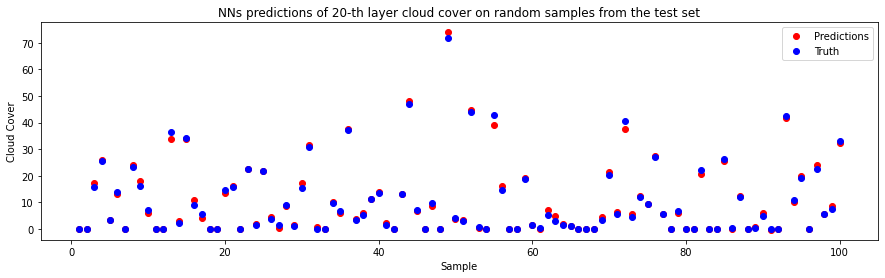

In [23]:
no_samples = 100
layer = 20
clc_pred = models[layer].predict(input_test_NN[layer][:no_samples])
clc_true = output_test_NN[layer][:no_samples]
a = np.linspace(1, no_samples, no_samples)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111, title='NNs predictions of %d-th layer cloud cover on random samples from the test set'%layer, 
                     xlabel='Sample', ylabel='Cloud Cover')
ax.plot(a, clc_pred, 'ro')
ax.plot(a, clc_true, 'bo')
ax.legend(['Predictions', 'Truth'])
fig.savefig('../figures/offline_testing_predictions_random_samples.pdf')

**Second visualization method** <br>
Mean profile of Cloud Cover on x-axis with Vertical Layer on y-axis. This time I can use the test set.

In [11]:
# Vertical layers
a = np.linspace(5, 31, 27)
# Cloud cover means for first model
clc_data_mean = []
clc_pred_mean = []
for i in range(27):
    clc_data_mean.append(np.mean(output_test_NN[i]))
    # Predicted cloud cover means
    pred_adj = np.minimum(np.maximum(models[i].predict(input_test_NN[i]), 0), 100)
    clc_pred_mean.append(np.mean(pred_adj, axis=0))

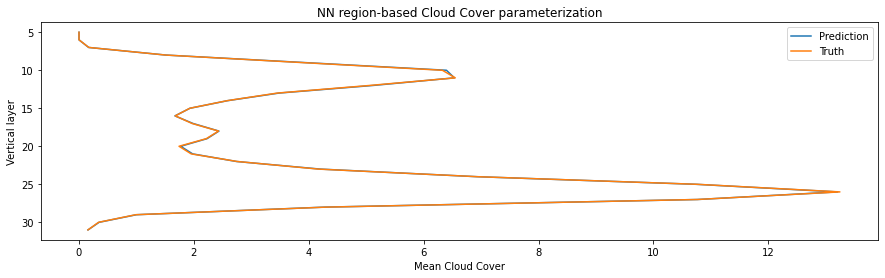

In [12]:
fig = plt.figure(figsize=(15,4))
# For model
ax_1 = fig.add_subplot(111, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='NN region-based Cloud Cover parameterization')
ax_1.plot(clc_pred_mean, a)
ax_1.plot(clc_data_mean, a)
plt.gca().invert_yaxis()
ax_1.legend(['Prediction', 'Truth'])
fig.savefig('../figures/offline_testing_mean_cloud_cover_NNs.pdf')

Mean profile with all NARVAL data

In [19]:
input_data = []
output_data = []

for i in range(n_layers):
    input_data.append(np.concatenate((input_train_NN[i], input_valid_NN[i], input_test_NN[i])))
    output_data.append(np.concatenate((output_train_NN[i], output_valid_NN[i], output_test_NN[i])))

In [21]:
# Vertical layers
a = np.linspace(5, 31, 27)
# Cloud cover means for first model
clc_data_mean = []
clc_pred_mean = []
for i in range(27):
    clc_data_mean.append(np.mean(output_data[i], dtype=np.float64))
    # Predicted cloud cover means
    pred_adj = np.minimum(np.maximum(models[i].predict(input_data[i]), 0), 100)
    clc_pred_mean.append(np.mean(pred_adj, axis=0))

In [22]:
clc_pred_mean

[array([0.00019869], dtype=float32),
 array([0.00028952], dtype=float32),
 array([0.17292088], dtype=float32),
 array([1.5057614], dtype=float32),
 array([3.9511752], dtype=float32),
 array([6.42019], dtype=float32),
 array([6.534646], dtype=float32),
 array([5.09313], dtype=float32),
 array([3.4730515], dtype=float32),
 array([2.5862944], dtype=float32),
 array([1.9298049], dtype=float32),
 array([1.6620936], dtype=float32),
 array([2.0024312], dtype=float32),
 array([2.4604807], dtype=float32),
 array([2.221365], dtype=float32),
 array([1.7741598], dtype=float32),
 array([1.9854069], dtype=float32),
 array([2.744725], dtype=float32),
 array([4.2037177], dtype=float32),
 array([6.894963], dtype=float32),
 array([10.748404], dtype=float32),
 array([13.222322], dtype=float32),
 array([10.732124], dtype=float32),
 array([4.2999697], dtype=float32),
 array([1.0032209], dtype=float32),
 array([0.34955263], dtype=float32),
 array([0.15560368], dtype=float32)]

In [23]:
clc_data_mean

[2.0516477693020423e-07,
 0.00034086927341436753,
 0.17661084202334312,
 1.4998438126611484,
 3.902263484035136,
 6.349001448225982,
 6.547815854066336,
 5.033804978480318,
 3.448304713902622,
 2.5793811697820677,
 1.92561651328619,
 1.667549647945401,
 1.9866840386031737,
 2.452039861399841,
 2.20654246164629,
 1.7451326114003243,
 1.9593509079281894,
 2.7583582117141883,
 4.166830828417757,
 6.908296338684412,
 10.76565897432415,
 13.262349346144319,
 10.728780853117888,
 4.325431446378538,
 0.9917836019502414,
 0.33945893908952796,
 0.1554966481012375]

**Plotting the difference from offline_testing_mean_cloud_cover_NNs.pdf**

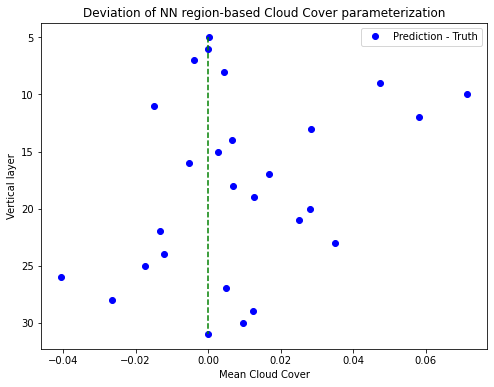

In [13]:
fig = plt.figure(figsize=(8,6))
# For model
ax_1 = fig.add_subplot(111, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='Deviation of NN region-based Cloud Cover parameterization')
ax_1.plot(np.squeeze(np.array(clc_pred_mean)) - np.array(clc_data_mean), a, 'bo')
ax_1.plot(0*a, a, 'g--')
plt.gca().invert_yaxis()
ax_1.legend(['Prediction - Truth'])
fig.savefig('../figures/offline_testing_mean_cloud_cover_NNs_diff.pdf')

**Third visualization method** <br>
Hovmöller diagram (time on x-axis with vertical layers on y-axis and NN mean clc in color) <br>
Looking at the first day here.

In [4]:
path = "/pf/b/b309170/my_work/NARVAL/data_var_vertinterp/"
timesteps_per_day = 24

ls = os.listdir(os.path.join(path, 'temp')) #Temperature as an arbitrary variable
days = set()
for j in range(len(ls)):
    day = ls[j].split(sep='_')[5] #Days
    days.add(day)

# Get one day
day = days.pop()
dfs = load_day(day, n_layers, path)

print(day) # Which day is it? It was the 29.12 for the diagrams below I think.

2013121900


In [37]:
# Where's the temporal information (27144=24*1024)?
# It's spaced 1024 entries apart:
rand_ind = np.random.randint(dfs[20].shape[0]-1024)
assert dfs[20]['clc'][rand_ind] == dfs[20]['clc_prev'][rand_ind+1024]

dfs[1].columns

Index(['qv_i-2', 'qv_i-1', 'qv_i', 'qv_i+1', 'qv_i+2', 'qc_i-2', 'qc_i-1',
       'qc_i', 'qc_i+1', 'qc_i+2', 'qi_i-2', 'qi_i-1', 'qi_i', 'qi_i+1',
       'qi_i+2', 'temp_i-2', 'temp_i-1', 'temp_i', 'temp_i+1', 'temp_i+2',
       'pres_i-2', 'pres_i-1', 'pres_i', 'pres_i+1', 'pres_i+2', 'rho_i-2',
       'rho_i-1', 'rho_i', 'rho_i+1', 'rho_i+2', 'zg_i-2', 'zg_i-1', 'zg_i',
       'zg_i+1', 'zg_i+2', 'fr_lake', 'clc_prev', 'clc'],
      dtype='object')

In [6]:
## Load data pertaining to a specific NN
n_samples_per_layer = dfs[0].shape[0]
n_features = dfs[0].shape[1] - 1

# Load the data into dictionaries. Can't use 3D tensors here as some features will be removed depending on the NN.
# One entry (time*hor x features matrix) in the dictionary per vertical layer
input_NN = {}
for i in range(n_layers):
    input_NN[i] = np.zeros((n_samples_per_layer, n_features))
    
data_clc = {}
for i in range(n_layers):
    data_clc[i] = np.zeros((n_samples_per_layer))
    
for i in range(n_layers):
    input_NN[i] = np.array(dfs[i])[:, :-1]
    data_clc[i] = np.array(dfs[i])[:, -1]

In [7]:
# We read the means and standard deviations from model_region_based_final_1.txt!
# I manually replaced nan's in the text-file by 1e+30 before reading the file.

means = {}
for i in range(n_layers):
    means[i] = np.zeros(n_features)
    
stds = {}
for i in range(n_layers):
    stds[i] = np.zeros(n_features)
    
layer = -1
with open(info_file, 'r') as file:
    while True:
        line = file.readline()
        # Retrieving the mean values
        if line.startswith('The mean values'):
            j = 0 # Feature entry in mean tensor
            layer += 1
            while True:
                line = file.readline()
                line_entries = line.split(' ')
                for i in range(1, len(line_entries)): # line_entries[0] doesn't contain numbers
                    if line_entries[i].startswith('['):
                        means[layer][j] = line_entries[i][1:]
                    elif line_entries[i].endswith(']'):
                        means[layer][j] = line_entries[i][:-1]
                    elif line_entries[i].endswith(']\n'):
                        means[layer][j] = line_entries[i][:-2]
                    elif line_entries[i] != '\n' and line_entries[i] != '':
                        means[layer][j] = line_entries[i]
                    j += 1
                if ']' in line:
                    break
                    
        if line.startswith('The standard deviation values'):
            j = 0 # Feature entry in mean tensor
            while True:
                line = file.readline()
                line_entries = line.split(' ')
                for i in range(1, len(line_entries)): # line_entries[0] doesn't contain numbers
                    if line_entries[i].startswith('['):
                        stds[layer][j] = line_entries[i][1:]
                    elif line_entries[i].endswith(']'):
                        stds[layer][j] = line_entries[i][:-1]
                    elif line_entries[i].endswith(']\n'):
                        stds[layer][j] = line_entries[i][:-2]
                    elif line_entries[i] != '\n' and line_entries[i] != '':
                        stds[layer][j] = line_entries[i]
                    j += 1
                if ']' in line:
                    break  
        # If the end of the file is reached            
        if not line:
            break

In [16]:
# We remove the input features with zero variance in the TRAINING set. We compute the resulting input dimension for the NN.
for i in range(n_layers):
    vars_to_remove = []
    for j in range(n_features):
        if np.var(input_train_NN[i][:, j]) == 0 or np.isnan(np.var(input_train_NN[i][:, j])): #We reuse input_train_NN here!
            vars_to_remove.append(j)
    input_NN[i] = np.delete(input_NN[i], vars_to_remove, axis=1)    
    means[i] = np.delete(means[i], vars_to_remove)
    stds[i] = np.delete(stds[i], vars_to_remove)

In [17]:
# for i in range(n_layers):
#     print(input_NN[i].shape)

In [18]:
# We standardize the input data according to model_region_based_final_1.txt
for j in range(n_layers):
    # For some reason for the two highest j the output is 'float' instead of np.float32/np.float64. 
    # This makes the data un-predictable by the tensorflow model
    if j > n_layers-3:
        input_NN[j] = ((input_NN[j] - means[j])/stds[j]).astype(np.float64)
    else:
        input_NN[j] = (input_NN[j] - means[j])/stds[j]

In [30]:
# All vertical layers from first time step
pred_clc_mat = np.zeros((timesteps_per_day, n_layers))
data_clc_mat = np.zeros((timesteps_per_day, n_layers))
for i in range(timesteps_per_day):
    for j in range(n_layers):
#         print(input_NN[j][i*1024:(i+1)*1024].shape)
        # Mean prediction for a specific time step and vertical layer
        pred_1 = models[j].predict(input_NN[j][i*1024:(i+1)*1024])
        pred_clc_mat[i,j] = np.mean(np.minimum(np.maximum(pred_1, 0), 100))   
        # Mean cloud cover for a specific time step and vertical layer
        data_clc_mat[i,j] = np.mean(data_clc[j][i*1024:(i+1)*1024])

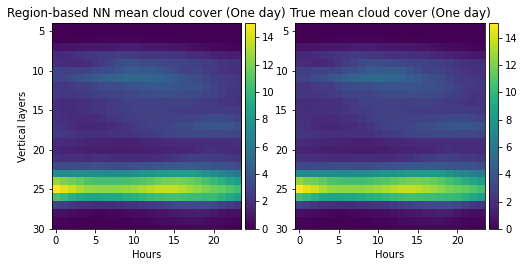

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm

capped_matrix = np.zeros((24, 31))
capped_matrix_data = np.zeros((24, 31))
capped_matrix[:, 4:] = pred_clc_mat
capped_matrix_data[:, 4:] = data_clc_mat
# t = np.linspace(1, 25, 25)
# v = np.linspace(9, 75)
# T, V = np.meshgrid(t, v)
fig = plt.figure(figsize=(8,8))
ax_2 = fig.add_subplot(122, xlabel='Hours', ylim=[30, 4], title='True mean cloud cover (One day)')
ims_2 = ax_2.imshow(np.transpose(capped_matrix_data))
# Colorbar axes
divider = make_axes_locatable(ax_2)
cax_2 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ims_2, cax=cax_2)

ax_1 = fig.add_subplot(121, xlabel='Hours', ylim=[30, 4], ylabel='Vertical layers', title='Region-based NN mean cloud cover (One day)')
ims_1 = ax_1.imshow(np.transpose(capped_matrix))
# Colorbar axes
divider = make_axes_locatable(ax_1)
cax_1 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ims_1, cax=cax_1)
fig.savefig('../figures/offline_testing_hovmoeller.pdf')

/pf/b/b309170/work/b309170/conda/envs/clouds113/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


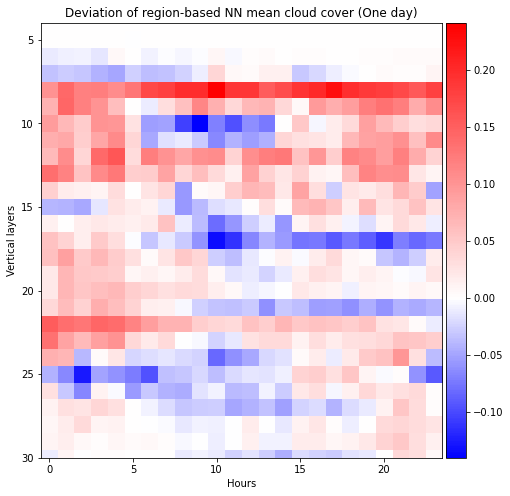

In [41]:
# Difference

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
from matplotlib.colors import DivergingNorm

capped_matrix = np.zeros((24, 31))
capped_matrix_data = np.zeros((24, 31))
capped_matrix[:, 4:] = pred_clc_mat
capped_matrix_data[:, 4:] = data_clc_mat
# t = np.linspace(1, 25, 25)
# v = np.linspace(9, 75)
# T, V = np.meshgrid(t, v)
fig = plt.figure(figsize=(8,8))
# ax_2 = fig.add_subplot(122, xlabel='Hours', ylim=[30, 4], title='True mean cloud cover (One day)')
# ims_2 = ax_2.imshow(np.transpose(capped_matrix_data))
# # Colorbar axes
# divider = make_axes_locatable(ax_2)
# cax_2 = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(ims_2, cax=cax_2)

ax_1 = fig.add_subplot(111, xlabel='Hours', ylim=[30, 4], ylabel='Vertical layers', title='Deviation of region-based NN mean cloud cover (One day)')
ims_1 = ax_1.imshow(np.transpose(capped_matrix - capped_matrix_data), norm=DivergingNorm(0), cmap='bwr')
# Colorbar axes
divider = make_axes_locatable(ax_1)
cax_1 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ims_1, cax=cax_1)
# fig.savefig('../figures/offline_testing_hovmoeller_diff.pdf')

**Forth visualization method** <br>
R2-value on x-axis with vertical layers on y-axis <br>

R2 = 1-SS_res/SS_tot, <br>
SS_res = total sum of squares (prop. to variance in the data) <br>
SS_tot = residual sum of squares

So R2 = 1 - MSE/Variance(Data), isn't it?

Best case: R2 = 1 <br>
If R2 < 0, then a constant output model would be better than the ML model.

In [10]:
input_data = []
output_data = []

In [11]:
for i in range(n_layers):
    input_data.append(np.concatenate((input_train_NN[i], input_valid_NN[i], input_test_NN[i])))
    output_data.append(np.concatenate((output_train_NN[i], output_valid_NN[i], output_test_NN[i])))

In [12]:
# MSE per layer

from tensorflow.keras import backend as K
import gc

clc_mse = []

for j in range(n_layers):
    # Predicting is much faster with predict_on_batch
    no_of_samples = input_data[j].shape[0]
    batch_size = no_of_samples//100
    for i in range(1 + no_of_samples//batch_size):
        if i == 0:
            pred = models[j].predict_on_batch(input_data[j][i*batch_size:(i+1)*batch_size])
        else:
            pred = np.concatenate((pred, models[j].predict_on_batch(input_data[j][i*batch_size:(i+1)*batch_size])), axis=0)
        K.clear_session()
        gc.collect()

    pred_adj = np.minimum(np.maximum(pred, 0), 100)  #Cloud Cover is enforced between 0 and 100. 
                                                     #This should also be done in practice

    clc_mse.append(np.mean((pred_adj[:, 0] - output_data[j])**2, axis=0, dtype=np.float64))

In [13]:
# Variance of the data
clc_data_var = []
for j in range(n_layers):
    clc_data_var.append(np.var(output_data[j], axis=0))
assert(len(clc_data_var) == len(clc_mse) == 27)

In [14]:
r2 = []
assert len(clc_mse) == len(clc_data_var) == 27
for i in range(27):
    r2.append(1 - clc_mse[i]/clc_data_var[i])

In [15]:
# The R2-values on the (not two!) uppermost layer is really bad 
r2[:1]

[-2131169.4218093962]

In [16]:
# Well, with such a low variance
clc_data_var[:2]

[5.61384722271271e-09, 0.0005831066729911401]

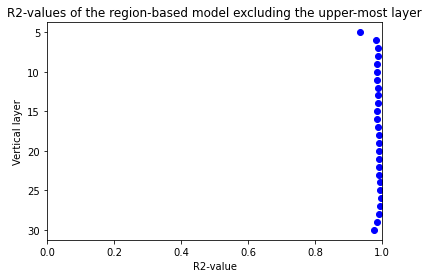

In [17]:
a = np.linspace(5, 30, 26)
fig = plt.figure()

ax = fig.add_subplot(111, xlim=(0, 1), title='R2-values of the region-based model excluding the upper-most layer',
                     xlabel='R2-value', ylabel='Vertical layer')
ax.plot(r2[1:], a, 'bo')
plt.gca().invert_yaxis()
fig.savefig('../figures/region_based_r2-values.pdf')

In [18]:
r2

[-2131169.4218093962,
 0.9340452725543076,
 0.9815382094872405,
 0.9875779569711387,
 0.9881498169204237,
 0.985849414939333,
 0.9845079819136472,
 0.9859554777867869,
 0.9890010192649976,
 0.9895664135327232,
 0.9874473960792923,
 0.985320558548991,
 0.9861261160817199,
 0.989554547743751,
 0.9907844996557563,
 0.9907635695408146,
 0.9910925442584202,
 0.9914023282208477,
 0.9918668692237637,
 0.9926304087669037,
 0.9941627854374602,
 0.9953104492050667,
 0.9962050284220396,
 0.9951965485999752,
 0.991702810938895,
 0.9858218918378474,
 0.9760560897393651]